# Hello Soft Clustering (GMM)
**GitHub:** https://github.com/pirsquareff/fisherface

Recall from HW1 we did K-means clustering. Fitting a GMM on a set of points can be considered as another method to do clustering but now with soft assignments.

Consider the same set of points we used in HW1

<img src="images/clustering-observation-in-xy-plane.png" width="35%" height="35%">

In class, we showed that we could fit a GMM on 1-dimensional data by using Expectation Maximization (EM). The algorithm for doing EM on N-dimensional GMM is very similar. The exact algorithm is as follows:

**Initialization:** Initialize the mixture weights, $\phi=\{m_{j}\}$, where $j$ is the mixture number, means of each Gaussian, $\mu_{j}$ (now a vector of $N$ dimensions), and covariance matrices of each Gaussian, $Σ_{j}$.<br>
**Expectation:** Find the soft assignments for each data point $w_{n, j}$ where $n$ corresponds to the sample index.
$$w_{n, j} = \frac{p(x_{n}; \overrightarrow{\mu_{j}}, \mathbf{Σ}_{j})m_{j}}{\sum_{j}p(x_{n}; \overrightarrow{\mu_{j}}, \mathbf{Σ}_{j})m_{j}}$$
$w_{n, j}$ means the probability that data point $n$ comes from Gaussian number $j$.<br>
<div class="alert alert-block alert-info">
**Multivariate Normal Distribution (MVN Distribution)**<br>
$$f(\mathbf{x}) = \frac{1}{(2\pi)^{d/2}|\mathbf{Σ}|^{1/2}}exp\{-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^T\mathbf{Σ}^{-1}(\mathbf{x}-\mathbf{\mu})\}$$
where $d$ is the dimension of data
</div>
**Maximization:** Update the model parameters, $\phi$, $\mu_{j}$, $Σ_{j}$.
$$m_{j} = \frac{1}{N}\sum_{n}w_{n, j}$$
$$\overrightarrow{\mu_{j}} = \frac{\sum_{n}w_{n,j}\overrightarrow{x_{n}}}{\sum_{n}w_{n,j}}$$
$$\mathbf{Σ}_{j} = \frac{\sum_{n}w_{n,j}(\overrightarrow{x_{n}}-\overrightarrow{\mu_{j}})(\overrightarrow{x_{n}}-\overrightarrow{\mu_{j}})^T}{\sum_{n}w_{n,j}}$$

<div class="alert alert-block alert-info">
The above equation is used for full covariance matrices. For our small toy example, we will use diagonal covariance matrices, which can be acquired by setting the off-diagonal values to zero. In other words, $\mathbf{Σ}_{(i, j)} = 0$, for $i \neq j$.
</div>

**Repeat:** Expectation and maximization step.

In [458]:
import numpy as np
from IPython.display import Latex
from IPython.display import Math
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [459]:
data_points = np.array([[1., 2.], [3., 3.], [2., 2.], [8., 8.], [6., 6.], [7., 7.], [-3., -3.], [-2., -4.], [-7., -7.]]) 

In [460]:
def latex_bmatrix(a):
    """Returns a LaTeX bmatrix
    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

In [461]:
def em(data, n_mixture, initial_mu = None, iterations = 1000, verbose = False):
    """Do expectation maximization (EM) on N-dimensional GMM
    :data: data in N-dimension
    :n_mixture: a number of mixture
    :initial_mu: initialized Gaussian means
    :iterations: a maximum round to do repeat step
    :verbose: set True to show significant values at each iteration
    """
    # n_data: number of data points
    # dimension: dimension of data points
    n_data, dimension = data.shape

    ## INITIALIZATION STEP ##
    # initialize mixture weight of each Gaussian equally (ϕ: phi)
    phi = [1./n_mixture] * n_mixture
    
    if initial_mu is not None:
        mu = np.array(initial_mu)
    else:
        # randomly initialize means of each Gaussian (μ: mu)
        mu = data[np.random.choice(n_data, size = n_mixture, replace = False), :]
    
    # initialize covariance matrices of each Gaussian (Σ: sigma)
    """
    numpy.eye(N)
    :N: Number of rows in the output.
    :return: A 2-D array w/ ones on the diagonal and zeros elsewhere.
    """
    sigma = [np.eye(dimension)] * n_mixture

    # initialize log_likelihoods
    log_likelihoods = []
    
    if(verbose):
        print("Initialization:")
        display(Math(r"m_{j}:"))
        for j in range(n_mixture):
            display(Latex(r"\begin{equation}m_{" + str(j) + "}=" + latex_bmatrix(np.matrix(phi[j])) + "\end{equation}"))
        display(Math(r"\mu_{j}:"))
        for j in range(n_mixture):
            display(Latex(r"\begin{equation}\mu_{" + str(j) + "}=" + latex_bmatrix(np.matrix(mu[j]).T) + "\end{equation}"))
        display(Math(r"\mathbf{Σ}_{j}:"))
        for j in range(n_mixture):
            display(Latex(r"\begin{equation}\mathbf{Σ}_{" + str(j) + "}=" + latex_bmatrix(sigma[j]) + "\end{equation}"))
        print()
    
    for i in range(iterations) :
        ## EXPECTATION STEP ##
        # set soft labels (w)
        w_numerator = np.zeros((n_data, n_mixture))
        for j in range(n_mixture):
            w_numerator[:, j] = phi[j] * multivariate_normal.pdf(data, mu[j], sigma[j])
        w = (w_numerator.T / np.sum(w_numerator, axis = 1)).T
        w_j = np.sum(w, axis = 0)
        
        ## MAXIMIZATION STEP ##
        for j in range(n_mixture):
            # update mixture weight
            phi[j] = 1. / n_data * w_j[j]
            
            # update sigma
            x_mu = np.matrix(data - mu[j])
            sigma[j] = np.array(np.dot(np.multiply(x_mu.T, w[:, j]), x_mu) / w_j[j])
            
            # set the off-diagonal values to zero
            sigma[j] = np.diag(np.diag(sigma[j]))
            
            # update mean
            mu[j] = np.sum(w[:, j] * data.T, axis = 1).T / w_j[j]
        
        # calulate log likelihood
        log_likelihood = np.sum(np.log(np.sum(w_numerator, axis = 1)))
        log_likelihoods.append(log_likelihood)
        
        if(verbose):
            print("EM Iteration: " + str(i + 1))
            display(Latex(r"\begin{equation}w_{n,j}=" + latex_bmatrix(w) + "\end{equation}"))
            display(Math(r"m_{j}:"))
            for j in range(n_mixture):
                display(Latex(r"\begin{equation}m_{" + str(j) + "}=" + latex_bmatrix(np.matrix(phi[j])) + "\end{equation}"))
            display(Math(r"\mu_{j}:"))
            for j in range(n_mixture):
                display(Latex(r"\begin{equation}\mu_{" + str(j) + "}=" + latex_bmatrix(np.matrix(mu[j]).T) + "\end{equation}"))
            display(Math(r"\mathbf{Σ}_{j}:"))
            for j in range(n_mixture):
                display(Latex(r"\begin{equation}\mathbf{Σ}_{" + str(j) + "}=" + latex_bmatrix(sigma[j]) + "\end{equation}"))
            print()
    return log_likelihoods, mu, sigma

**Using 3 mixtures, initialize your Gaussian with means $(3,3)$, $(2,2)$, and $(-3,-3)$, and standard Covariance, $\textbf{I}$, the identity matrix. Use equal mixture weights as the initial weights. Repeat three iterations of EM. Write down $w_{n,j}, m_{j}, \mu_{j}, \mathbf{Σ}_{j}$ for each EM iteration. (You may do the calculations by hand or write code to do so)**

<font color=red>**Answer**</font><br>

In [462]:
init_mu_1 = np.array([[3., 3.], [2., 2.], [-3., -3.]])
log_likelihoods_1, mu_1, sigma_1 = em(data = data_points, n_mixture = 3, initial_mu = init_mu_1, iterations = 3, verbose = True)

Initialization:


<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


EM Iteration: 1


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


EM Iteration: 2


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


EM Iteration: 3


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

**Plot the log likelihood of the model given the data after each EM step. In other words, plot $\log\prod_np(\overrightarrow{x_{n}}|\phi, \overrightarrow{\mu},\mathbf{Σ})$. Does it goes up every iteration just as we learned in class?**<br>
<font color=red>**Answer**</font><br>
> Yes, the log likelihood goes up every iteration.

[-93.173901237559477, -42.103074420132309, -38.54343920672342]


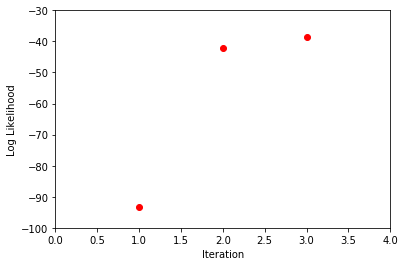

In [463]:
print(log_likelihoods_1)
plt.plot([i + 1 for i in range(len(log_likelihoods_1))], log_likelihoods_1, 'ro')
plt.axis([0, 4, -100, -30])
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.show()

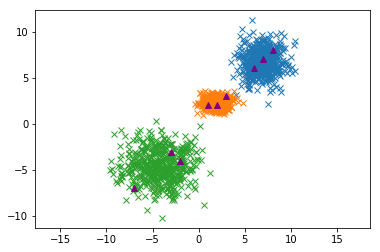

In [464]:
for i in range(len(mu_1)):
    x, y = np.random.multivariate_normal(mu_1[i], sigma_1[i], 500).T
    plt.plot(x, y, 'x')
    plt.axis('equal')
plt.plot(data_points.T[0], data_points.T[1], '^', color = 'purple')
plt.show()

**Using 2 mixtures, initialize your Gaussian with means $(3,3)$ and $(-3,-3)$, and standard Covariance, $\mathbf{I}$, the identity matrix. Use equal mixture weights as the initial weights. Repeat three iterations of EM. Write down $w_{n, j}, m_{j}, \mu_{j}, \mathbf{Σ}_{j}$ for each EM iteration.**

<font color=red>**Answer**</font><br>

In [465]:
init_mu_2 = np.array([[3., 3.], [-3., -3.]])
log_likelihoods_2, mu_2, sigma_2 = em(data = data_points, n_mixture = 2, initial_mu = init_mu_2, iterations = 3, verbose = True)

Initialization:


<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


EM Iteration: 1


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


EM Iteration: 2


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


EM Iteration: 3


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

**Plot the log likelihood of the model given the data after each EM step.**

<font color=red>**Answer**</font><br>

[-93.27921820745587, -46.888870101861045, -46.292975286199031]


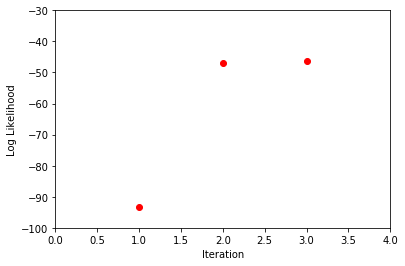

In [466]:
print(log_likelihoods_2)
plt.plot([i + 1 for i in range(len(log_likelihoods_2))], log_likelihoods_2, 'ro')
plt.axis([0, 4, -100, -30])
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.show()

[[ 4.49960686  4.66618544]
 [-3.99986439 -4.66641867]]


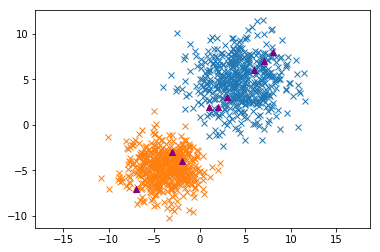

In [467]:
print(mu_2)
for i in range(len(mu_2)):
    x, y = np.random.multivariate_normal(mu_2[i], sigma_2[i], 500).T
    plt.plot(x, y, 'x')
    plt.axis('equal')
plt.plot(data_points.T[0], data_points.T[1], '^', color = 'purple')
plt.show()

**Compare the log likelihood between using two mixtures and three mixtures. Which one has the better likelihood?**<br>
Compare $BIC = -2logL + tlogn$ of the two models<br>
where <br>
$t$ = number of parameters in the model<br>
$n$ = number of data points

In [468]:
# Manually calculate Bayesian Information Criterion (BIC)
# Number of parameters in the 3-mixture model = 8
bic_1 = -2. * log_likelihoods_1[-1] + 8. * np.log(data_points.shape[0])

# Number of parameters in the 3-mixture model = 5
bic_2 = -2. * log_likelihoods_2[-1] + 5. * np.log(data_points.shape[0])

In [469]:
bic_1

94.6646750321366

In [470]:
bic_2

103.57207345907916

<font color=red>**Answer**</font><br>
> After penalizing the log likelihood based on BIC, BIC of 3-mixture model is less than BIC of 2-mixture one, so log likelihood using three mixtures is better.